<a href="https://colab.research.google.com/github/tozanni/hdw_interpretability/blob/main/03-Shap-Cervical-Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data prep thanks to:
https://www.kaggle.com/code/renadope/cervical-cancer-classification-99-4-recall


In [1]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 5.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np

# Some sklearn tools for preprocessing.
# ColumnTransformer was introduced in 0.20 so make sure you have this version
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Our algorithms, by from the easiest to the hardest to intepret.
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm.sklearn import LGBMClassifier

import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
import numpy as np
risk_factor_df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00383/risk_factors_cervical_cancer.csv")
#risk_factor_df.head()

In [4]:
from sklearn.impute import SimpleImputer

#these columns are not of type object, but are of type numeric
cols_to_convert = ['Number of sexual partners', 'First sexual intercourse', 'Num of pregnancies', 'Smokes',
                   'Smokes (years)', 'Smokes (packs/year)', 'Hormonal Contraceptives',
                   'Hormonal Contraceptives (years)', 'IUD', 'IUD (years)', 'STDs', 'STDs (number)',
                   'STDs:condylomatosis', 'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
                   'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis', 'STDs:pelvic inflammatory disease',
                   'STDs:genital herpes', 'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV', 'STDs:Hepatitis B',
                   'STDs:HPV', 'STDs: Time since first diagnosis',
                   'STDs: Time since last diagnosis']
# for i in range(0,len(cols_to_convert)):
#     print("{}={}".format(i,cols_to_convert[i]))
risk_factor_df[cols_to_convert] = risk_factor_df[cols_to_convert].apply(pd.to_numeric, errors="coerce")
risk_factor_df[cols_to_convert].fillna(np.nan, inplace=True)
imp = SimpleImputer(strategy="median")
X = imp.fit_transform(risk_factor_df)
risk_factor_df = pd.DataFrame(X, columns=list(risk_factor_df.columns))


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [5]:
risk_factor_df["Age"] = risk_factor_df["Age"].astype(int)

In [6]:
std_cols = {'STDs:condylomatosis','STDs:cervical condylomatosis','STDs:vaginal condylomatosis',
            'STDs:vulvo-perineal condylomatosis','STDs:syphilis','STDs:pelvic inflammatory disease',
            'STDs:genital herpes','STDs:molluscum contagiosum','STDs:AIDS',
            'STDs:HIV','STDs:Hepatitis B','STDs:HPV'}

#risk_factor_df["total_std"] = risk_factor_df[list(std_cols)].sum(axis=1)
#std_agg = risk_factor_df.groupby("age_cat", as_index=False)[list(std_cols)].sum()

In [7]:
test_cols = ["Hinselmann", "Schiller", "Citology", "Biopsy"]
risk_factor_df["total_tests"] = risk_factor_df[test_cols].sum(axis = 1)

In [8]:
to_int_and_beyond = {"total_tests",
                     #"total_std",
                     "Smokes","Biopsy","Dx:Cancer","Num of pregnancies","Number of sexual partners","First sexual intercourse",
                     "Hormonal Contraceptives","IUD","STDs","STDs (number)","STDs: Number of diagnosis","Dx:CIN","Dx:HPV","Dx","Hinselmann",
                     "Schiller","Biopsy","Citology"}

to_int_and_beyond = to_int_and_beyond.union(std_cols)

for col in to_int_and_beyond:
    risk_factor_df[col] = risk_factor_df[col].astype(int)

In [9]:
y = risk_factor_df["Dx:Cancer"].copy()

X = risk_factor_df[["Number of sexual partners","Hormonal Contraceptives","Smokes","Num of pregnancies","STDs (number)","IUD"]]
#X = risk_factor_df.drop(risk_factor_df.iloc[:, 13:36],axis = 1)

In [10]:
from imblearn.over_sampling import ADASYN, SMOTE
#adasyn = ADASYN(random_state=42)
#X_adasyn, y_adasyn = adasyn.fit_resample(X,y)

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X,y)


In [11]:
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X_adasyn, y_adasyn, test_size=0.2, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

In [12]:
# Random Forest
rf_model = RandomForestClassifier(class_weight="balanced", n_estimators=150, n_jobs=-1, min_samples_split=.01, max_depth=15)
rf_model.fit(X_train, y_train)

# LightGBM
lgb_model = LGBMClassifier(class_weight="balanced", n_jobs=-1,max_depth=10, min_child_samples=40, n_estimators=50)
lgb_model.fit(X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 678, number of negative: 666
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30
[LightGBM] [Info] Number of data points in the train set: 1344, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

LGBMClassifier(class_weight='balanced', max_depth=10, min_child_samples=40,
               n_estimators=50, n_jobs=-1)

In [23]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = lgb_model.predict(X_test)
print("Accuracy is ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Accuracy is  0.7321428571428571
              precision    recall  f1-score   support

           0       0.74      0.74      0.74       174
           1       0.72      0.72      0.72       162

    accuracy                           0.73       336
   macro avg       0.73      0.73      0.73       336
weighted avg       0.73      0.73      0.73       336



In [24]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = rf_model.predict(X_test)
print("Accuracy is ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy is  0.7589285714285714
              precision    recall  f1-score   support

           0       0.75      0.81      0.78       174
           1       0.78      0.70      0.74       162

    accuracy                           0.76       336
   macro avg       0.76      0.76      0.76       336
weighted avg       0.76      0.76      0.76       336



LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


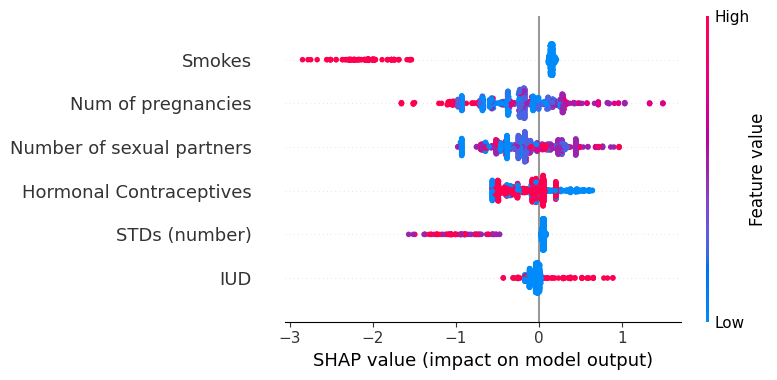

In [13]:
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values[1], X)

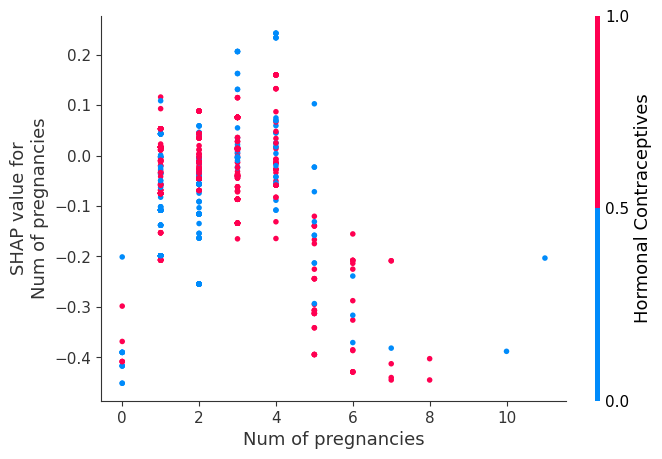

In [21]:
shap.dependence_plot("Num of pregnancies", shap_values[1], X)

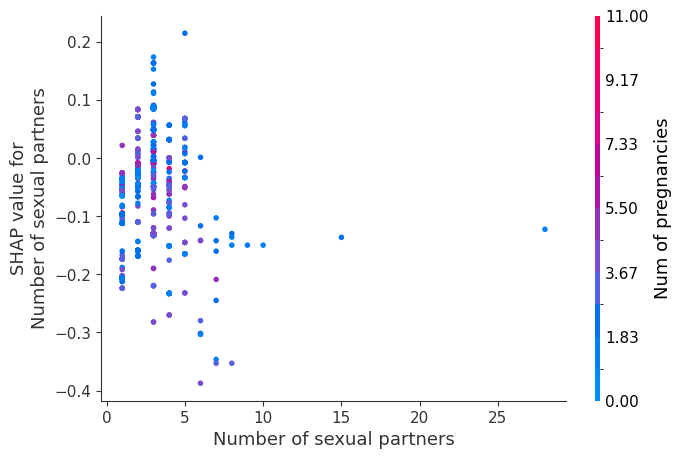

In [22]:
shap.dependence_plot("Number of sexual partners", shap_values[1], X)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


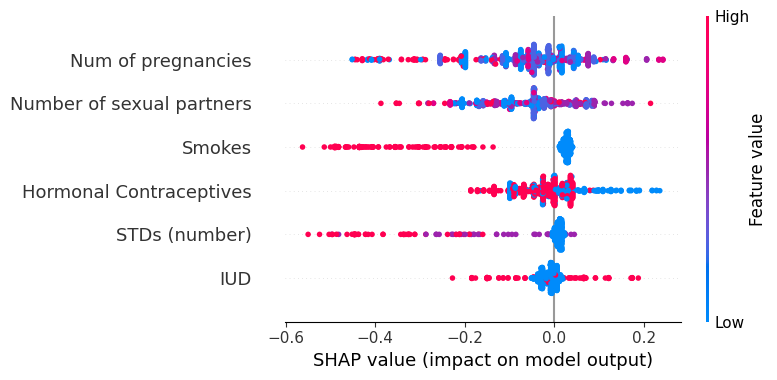

In [16]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values[1], X)

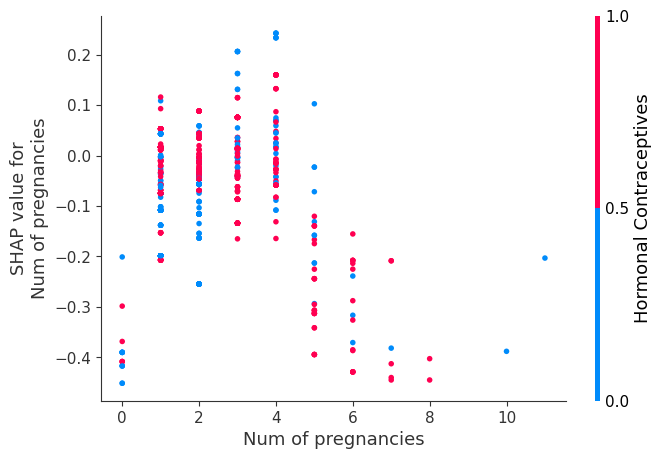

In [19]:
shap.dependence_plot("Num of pregnancies", shap_values[1], X)

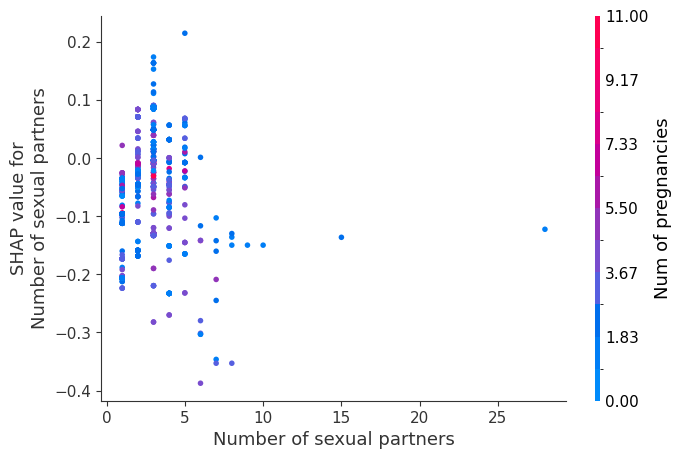

In [20]:
shap.dependence_plot("Number of sexual partners", shap_values[1], X)